<a href="https://www.kaggle.com/code/aisuko/text-to-image-with-diffusers-pipeline?scriptVersionId=164203327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we are going to use text to generate an image by using pipeline from diffusers.

In [1]:
# %%capture
!pip install diffusers==0.26.3
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.15.1
    Uninstalling huggingface-hub-0.15.1:
      Successfully uninstalled huggingface-hub-0.15.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.3.1
    Uninstalling safetensors-0.3.1:
      Successfully uninstalled safetensors-0.3.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation:

In [2]:
import os
import torch

os.environ['MODEL_NAME']='CompVis/stable-diffusion-v1-4'

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

print(torch_device)

cuda


# Loading the Components

Load all these components with the `from_pretrained()` method.

In [3]:
from PIL import Image

from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(os.getenv('MODEL_NAME'), subfolder="vae")
vae.to(torch_device)
print(vae)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [4]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(os.getenv('MODEL_NAME'), subfolder="tokenizer")
print(tokenizer)

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


In [5]:
from transformers import CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(os.getenv('MODEL_NAME'), subfolder = "text_encoder")
text_encoder.to(torch_device)
print(text_encoder)

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [6]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(os.getenv('MODEL_NAME'), subfolder = "unet")
unet.to(torch_device)
print(unet)

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

## Exchange to UniPCMultistepScheduler

It is easy to change to other schedulers

In [7]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(os.getenv('MODEL_NAME'), subfolder="scheduler")
print(scheduler)

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

UniPCMultistepScheduler {
  "_class_name": "UniPCMultistepScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



# Create text embeddings

**Tokenizing** the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

In [8]:
prompt =["a photograph of a girl from Italy in Pierre-Auguste Renoir style"]
# default weight of Stable Diffusion
height = 512
width = 512
# Number of denoising steps
num_inference_steps = 5
# Scale for classifier-free guidance
guidance_scale = 7.5
# Seed generator to create the initial latent noise
seed = torch.manual_seed(0)
batch_size=len(prompt)

text_input = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=tokenizer.model_max_length, 
    truncation=True,
    return_tensors="pt"
)

print(text_input)

{'input_ids': tensor([[49406,   320,  8853,   539,   320,  1611,   633,  4052,   530, 11985,
           268,  2610,  2686, 11520,   742,  1844, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


In [9]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
print(text_embeddings)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-1.1319, -1.5083,  0.3222,  ...,  0.2772,  0.9637, -0.0155],
         [-1.1328, -1.4901,  0.3253,  ...,  0.2817,  0.9778, -0.0151],
         [-1.0940, -1.4156,  0.3592,  ...,  0.2724,  0.9886, -0.0305]]],
       device='cuda:0')


## Generate the Unconditional Text Embeddings

Generate the unconditional text embeddings for the padding token. These need to have the same shape(batch-size and seq_length) as the conditional text_embeddings:

In [10]:
max_length=text_input.input_ids.shape[-1]
uncond_input =tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
print(uncond_embeddings)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


## Concatenation embeddings

Concatenate the condifitional and unconditional embeddings into a batch to avoid doing two forward passes

In [11]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(text_embeddings)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-1.1319, -1.5083,  0.3222,  ...,  0.2772,  0.9637, -0.0155],
         [-1.1328, -1.4901,  0.3253,  ...,  0.2817,  0.9778, -0.0151],
         [-1.0940, -1.4156,  0.3592,  ...,  0.2724,  0.9886, -0.0305]]],
       device='cuda:0', grad_fn=<CatBackward0>)


# Create random noise

**Generating some initial random noise as a starting point for the diffusion process.** This is the latent representation of the image, and it'll be gradually denoised. At this point, the latent image is snaller than the final image size but that's okay though because the model will transform it into the final 512x512 image dimensions later.

In [12]:
latents= torch.randn(
    batch_size,
    unet.in_channels,
    height // 8,
    width // 8,
    generator=seed,
)

latents =latents.to(torch_device)
print(latents)

tensor([[[[-1.1258, -1.1524, -0.2506,  ..., -1.2341,  1.8197, -0.5515],
          [-0.5692,  0.9200,  1.1108,  ...,  1.1648,  0.9234,  1.3873],
          [-0.8834, -0.4189, -0.8048,  ..., -0.9944, -1.1894, -1.1959],
          ...,
          [ 0.0859, -0.3592, -2.4972,  ..., -1.0989, -0.2155,  0.3364],
          [ 0.5901, -0.8325, -1.3715,  ...,  1.0564, -0.1504,  0.7420],
          [ 0.7272, -0.2612,  0.0124,  ..., -3.0357, -1.7288,  0.6020]],

         [[ 1.9476,  1.0077, -0.1007,  ..., -0.1173, -0.6841,  0.5988],
          [-0.2579, -1.0667, -0.7595,  ..., -0.1600,  1.0375,  1.2084],
          [ 1.3706, -0.0510,  2.6697,  ...,  0.1930, -2.0206, -0.5840],
          ...,
          [-1.5910,  1.0099,  0.2331,  ..., -0.5705, -0.8428, -1.2050],
          [-1.6555,  0.7469,  1.6022,  ..., -0.8822,  0.3436, -0.3445],
          [-0.0718,  0.8205, -0.0775,  ..., -0.7476, -1.0687, -0.1856]],

         [[ 0.2652, -0.7908,  0.9808,  ...,  0.4130, -0.7824,  1.7467],
          [-0.0583,  0.9223,  

/tmp/ipykernel_26/639320710.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  unet.in_channels,


# Denoise the image

Start by scaling the input with the inital noise distribution ***sigma*** the noise scale value, which is required for improved schedulers like UniPCMultistepScheduler:

In [13]:
latents = latents * scheduler.init_noise_sigma
print(latents)

tensor([[[[-1.1258, -1.1524, -0.2506,  ..., -1.2341,  1.8197, -0.5515],
          [-0.5692,  0.9200,  1.1108,  ...,  1.1648,  0.9234,  1.3873],
          [-0.8834, -0.4189, -0.8048,  ..., -0.9944, -1.1894, -1.1959],
          ...,
          [ 0.0859, -0.3592, -2.4972,  ..., -1.0989, -0.2155,  0.3364],
          [ 0.5901, -0.8325, -1.3715,  ...,  1.0564, -0.1504,  0.7420],
          [ 0.7272, -0.2612,  0.0124,  ..., -3.0357, -1.7288,  0.6020]],

         [[ 1.9476,  1.0077, -0.1007,  ..., -0.1173, -0.6841,  0.5988],
          [-0.2579, -1.0667, -0.7595,  ..., -0.1600,  1.0375,  1.2084],
          [ 1.3706, -0.0510,  2.6697,  ...,  0.1930, -2.0206, -0.5840],
          ...,
          [-1.5910,  1.0099,  0.2331,  ..., -0.5705, -0.8428, -1.2050],
          [-1.6555,  0.7469,  1.6022,  ..., -0.8822,  0.3436, -0.3445],
          [-0.0718,  0.8205, -0.0775,  ..., -0.7476, -1.0687, -0.1856]],

         [[ 0.2652, -0.7908,  0.9808,  ...,  0.4130, -0.7824,  1.7467],
          [-0.0583,  0.9223,  

The last step is to create the ***denoising loop*** that'll progressively transform the pure noise in latents to an image described by the prompt.

The denoising loop:
* Setting the scheduler's timesteps to use during denoising
* Iterating over the timesteps
* At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample

In [14]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input=torch.cat([latents]*2)
    latent_model_input=scheduler.scale_model_input(latent_model_input, timesteps=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text =noise_pred.chunk(2)
    noise_pred= noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t-> x_t-1
    latents=scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/5 [00:00<?, ?it/s]

# Decode the image

The final step is to use the vae to decode the latent representation into an image and get the decoded output with sample:

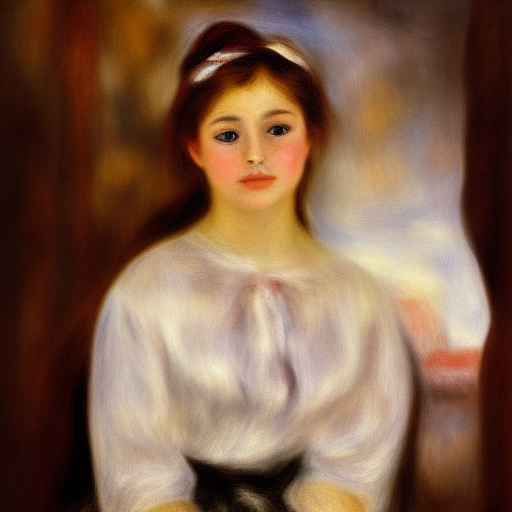

In [15]:
# scale and decode the image latents with vae

latents = 1/0.18215* latents
with torch.no_grad():
    image =vae.decode(latents).sample
    
image = (image /2+0.5).clamp(0, 1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images= (image*255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]